# Выбор локации для скважины

Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 100 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

# Описание данных

Данные геологоразведки трёх регионов находятся в файлах: 
- /datasets/geo_data_0.csv
- /datasets/geo_data_1.csv
- /datasets/geo_data_2.csv

Столбцы в таблицах:
- id — уникальный идентификатор скважины;
- f0, f1, f2 — три признака точек (неважно, что они означают, но сами признаки значимы);
- product — объём запасов в скважине (тыс. баррелей).

# Условия задачи:

- Для обучения модели подходит только линейная регрессия (остальные — недостаточно предсказуемые).
- При разведке региона исследуют 500 точек, из которых с помощью машинного обучения выбирают 200 лучших для разработки.
- Бюджет на разработку скважин в регионе — 10 млрд рублей.
- При нынешних ценах один баррель сырья приносит 450 рублей дохода. Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей.
- После оценки рисков нужно оставить лишь те регионы, в которых вероятность убытков меньше 2.5%. Среди них выбирают регион с наибольшей средней прибылью.

## Загрузка и подготовка данных

In [1]:
pip install phik -q

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np
import matplotlib
import phik
import matplotlib.pyplot as plt
import scipy.stats as stats

from tqdm import tqdm  # для прогресс-бара

from matplotlib.pyplot import figure
from math import factorial
from math import sqrt
from scipy import stats as st
from scipy.stats import binom, norm
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import (
    mean_squared_error, 
    mean_absolute_error, 
    r2_score, accuracy_score, 
    confusion_matrix, 
    recall_score, 
    precision_score
)

from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score

In [3]:
RANDOM_STATE = 42
TEST_SIZE = 0.25

In [4]:
try:
    # локальный путь к файлу, который открывается у меня
    geo_data_0 = pd.read_csv('geo_data_0.csv')
except:
    # Путь к файлу который открывается в тренажёре/у ревьювера
    geo_data_0 = pd.read_csv('/datasets/geo_data_0.csv')

geo_data_0

,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647
...,...,...,...,...,...
99995,DLsed,0.971957,0.370953,6.075346,110.744026
99996,QKivN,1.392429,-0.382606,1.273912,122.346843
99997,3rnvd,1.029585,0.018787,-1.348308,64.375443
99998,7kl59,0.998163,-0.528582,1.583869,74.040764


In [5]:
try:
    # локальный путь к файлу, который открывается у меня
    geo_data_1 = pd.read_csv('geo_data_1.csv')
except:
    # Путь к файлу который открывается в тренажёре/у ревьювера
    geo_data_1 = pd.read_csv('/datasets/geo_data_1.csv')

geo_data_1

,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305
...,...,...,...,...,...
99995,QywKC,9.535637,-6.878139,1.998296,53.906522
99996,ptvty,-10.160631,-12.558096,5.005581,137.945408
99997,09gWa,-7.378891,-3.084104,4.998651,137.945408
99998,rqwUm,0.665714,-6.152593,1.000146,30.132364


In [6]:
try:
    # локальный путь к файлу, который открывается у меня
    geo_data_2 = pd.read_csv('geo_data_2.csv')
except:
    # Путь к файлу который открывается в тренажёре/у ревьювера
    geo_data_2 = pd.read_csv('/datasets/geo_data_2.csv')

geo_data_2

,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746
...,...,...,...,...,...
99995,4GxBu,-1.777037,1.125220,6.263374,172.327046
99996,YKFjq,-1.261523,-0.894828,2.524545,138.748846
99997,tKPY3,-1.199934,-2.957637,5.219411,157.080080
99998,nmxp2,-2.419896,2.417221,-5.548444,51.795253


In [7]:
geo_data_0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


In [8]:
geo_data_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


In [9]:
geo_data_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


In [10]:
geo_data_0.duplicated().sum()

0

In [11]:
geo_data_1.duplicated().sum()

0

In [12]:
geo_data_2.duplicated().sum()

0

<font color='Black'><b>Вывод после загрузки и изучения данных:  </b></font><br>

- В данных нет пропусков.
- Данные в таблицах соответствуют описанию.
- Тип данных в файлах правильный.
- В данных нет дубликатов.

## Обучение и проверка модели

Изучим взаимосвязь между признаками: рассчитаем коэффициенты корреляции между всеми признаками.

interval columns not set, guessing: ['f0', 'f1', 'f2', 'product']


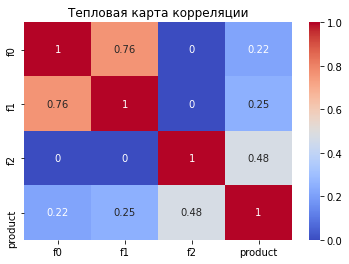

In [13]:
df = geo_data_0.drop(['id'], axis=1)
phik_matrix = df.phik_matrix()
sns.heatmap(phik_matrix, annot=True, cmap='coolwarm')
plt.title('Тепловая карта корреляции')
plt.show()

interval columns not set, guessing: ['f0', 'f1', 'f2', 'product']


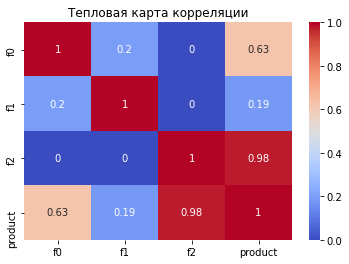

In [14]:
df = geo_data_1.drop(['id'], axis=1)
phik_matrix = df.phik_matrix()
sns.heatmap(phik_matrix, annot=True, cmap='coolwarm')
plt.title('Тепловая карта корреляции')
plt.show()

прямая корреляция с целевым признаком приведет к утечке данных при обучении модели

interval columns not set, guessing: ['f0', 'f1', 'f2', 'product']


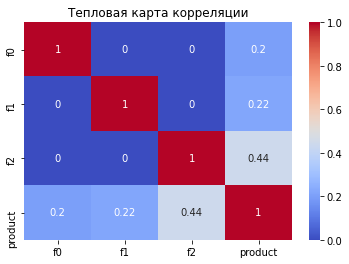

In [15]:
df = geo_data_2.drop(['id'], axis=1)
phik_matrix = df.phik_matrix()
sns.heatmap(phik_matrix, annot=True, cmap='coolwarm')
plt.title('Тепловая карта корреляции')
plt.show()

Удалим из датасетов столбцы id, т.к. обозначения скважин не влияют на целевой признак product - объём запасов в скважине (тыс. баррелей):

In [16]:
data_0 = geo_data_0.drop('id', axis=1)
data_1 = geo_data_1.drop('id', axis=1)
data_2 = geo_data_2.drop('id', axis=1)

Сделаем визуальную оценку нормальности распределений данных в трех датасетах:

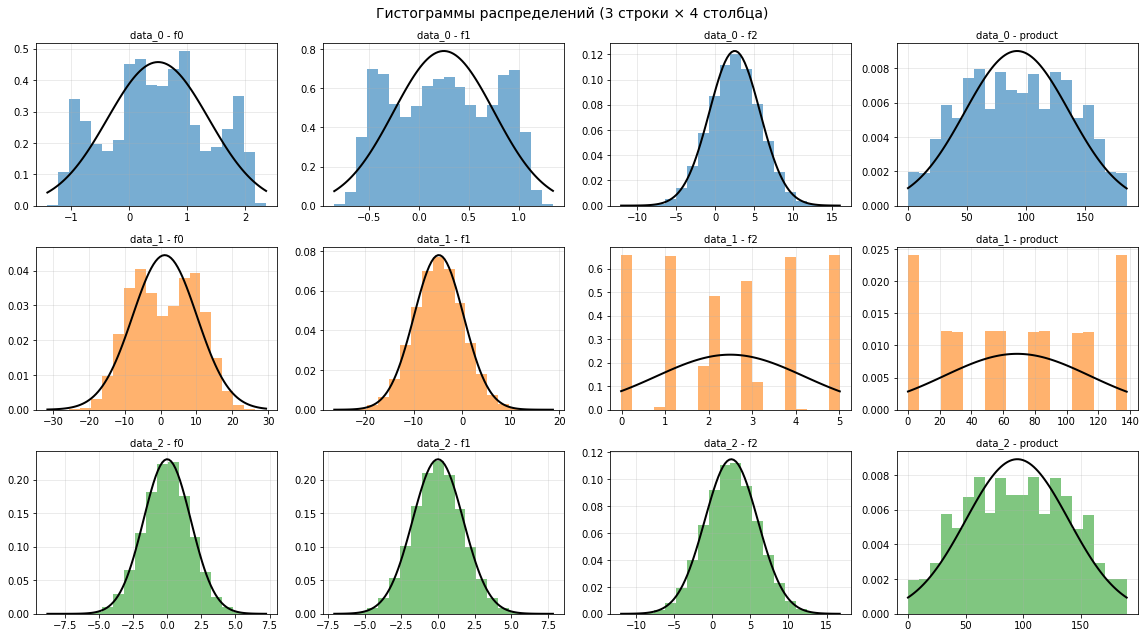

In [17]:
datasets = {'data_0': data_0, 'data_1': data_1, 'data_2': data_2}
colors = ['#1f77b4', '#ff7f0e', '#2ca02c']

# Гистограммы с кривой нормального распределения
plt.figure(figsize=(16, 9))  # Широкий формат для 4 графиков в строку

for i, (name, data) in enumerate(datasets.items()):
    for j, col in enumerate(data.columns):
        plt.subplot(3, 4, i * 4 + j + 1)  # 3 строки, 4 столбца, индекс i*4 + j + 1
        plt.hist(data[col], bins=20, density=True, alpha=0.6, color=colors[i])
        
        # Наложение кривой нормального распределения
        mu, std = data[col].mean(), data[col].std()
        x = np.linspace(data[col].min(), data[col].max(), 100)
        plt.plot(x, stats.norm.pdf(x, mu, std), 'k', linewidth=2)
        
        plt.title(f'{name} - {col}', fontsize=10)
        plt.grid(alpha=0.3)

plt.suptitle('Гистограммы распределений (3 строки × 4 столбца)', fontsize=14)
plt.tight_layout()
plt.show()

по графикам видно, что не все данные распределены нормально. Критичных выбросов нет. 

Обучение модели линейной регрессии:

In [18]:
scaler = StandardScaler() 
predictions_mean = []
predictions_valid = [] # список предсказаний по объёму сырья в скважине на валидационной выборке

y_train = []
y_valid = []

def function(X, y, num_col_names):
    # разделим данные на тренировочные и валидационные, зафиксируем random_state
    X_train, X_valid, y_train, y_valid = train_test_split(
        X, 
        y, 
        test_size=TEST_SIZE,
        random_state=RANDOM_STATE)

    ## подготовка признаков (масштабирование)
       
    X_train_scaled = scaler.fit_transform(X_train[num_col_names])
    X_valid_scaled = scaler.transform(X_valid[num_col_names])
    
    # создаём тренировочный и валидационный датафреймы из отмасштабированных данных

    X_train = pd.DataFrame(X_train_scaled, columns=num_col_names)
    X_valid = pd.DataFrame(X_valid_scaled, columns=num_col_names)
    
  
    # обучение модели и получение предсказаний на валидационных данных
    model_lr  = LinearRegression()
    model_lr.fit(X_train, y_train)
    predictions = model_lr.predict(X_valid)
    
    # список предсказаний по объёму сырья в скважине и список правильных ответов    
    predictions_mean.append(round(predictions.mean(),0))
    predictions_valid.append(predictions) 
    y_train.append(y_train.reset_index(drop=True))
    y_valid.append(y_valid.reset_index(drop=True))
    
    residuals = y_valid - predictions # рассчитаем остатки
    
    r2 = r2_score(y_valid, predictions)
    print('R^2 =', r2)
    print('МАЕ =', mean_absolute_error(y_valid, predictions))
    print('MSE =', mean_squared_error(y_valid, predictions))
    print('RMSE =', np.sqrt(mean_squared_error(y_valid, predictions)))
    
   
    print("Средний запас предсказанного сырья: {0:.2f} тыс. баррелей.". \
          format(predictions.mean()))


    # графики по количественным признакам 
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
    axes[0].hist(residuals)
    axes[0].set_title('Гистограмма распределения остатков')
    axes[0].set_xlabel('Остатки')

    axes[1].scatter(predictions, residuals)
    axes[1].set_xlabel('Предсказания модели')
    axes[1].set_ylabel('Остатки')
    axes[1].set_title('Анализ дисперсии')
    plt.show()
    
    return y_train, y_valid 

In [19]:
X_0 = geo_data_0.drop(['id', 'product'], axis=1) # входные признаки
y_0 = geo_data_0['product'] # целевой признак

In [20]:
num_col_names = ['f0', 'f1', 'f2']

R^2 = 0.2728287328173471
МАЕ = 31.047681538788183
MSE = 1425.5608700093812
RMSE = 37.75660035026169
Средний запас предсказанного сырья: 92.40 тыс. баррелей.


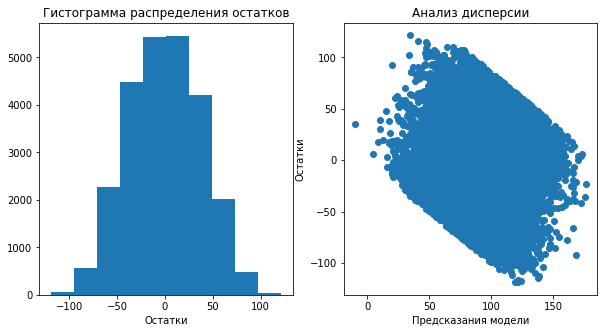

In [21]:
y_train_0, y_valid_0 = function(X_0, y_0, num_col_names)

MAE - Значение MAE говорит о том, что модель в среднем ошибается на 31,05 тыс. баррелей при прогнозировании объём запасов в скважине.

R² - чем ближе к единице её значение, тем точнее предсказывает модель
R² < 0.7 → возможно, не хватает значимых предикторов

На первом графике показано распределение остатков (разниц между фактическими и предсказанными значениями):
- Остатки сосредоточены около 0 (хороший признак)

Второй график проверяет гомоскедастичность (постоянство дисперсии остатков):
- Видна воронкообразная форма: дисперсия остатков растёт с увеличением предсказаний → гетероскедастичность. Это нарушает одно из условий линейной регрессии.

R^2 = 0.9996245232002449
МАЕ = 0.7170119535682558
MSE = 0.7925986566392023
RMSE = 0.8902801001028846
Средний запас предсказанного сырья: 68.71 тыс. баррелей.


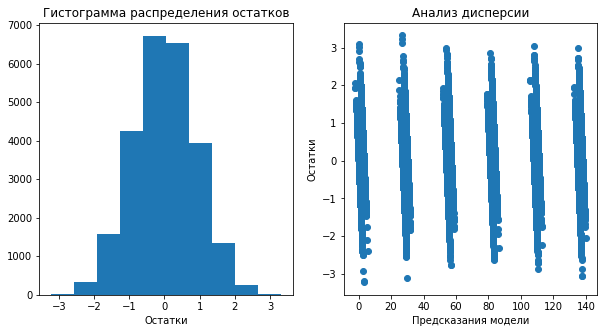

In [22]:
X_1 = geo_data_1.drop(['id', 'product'], axis=1) # входные признаки
y_1 = geo_data_1['product'] # целевой признак
num_col_names_1 = ['f0', 'f1', 'f2']
y_train_1, y_valid_1 = function(X_1, y_1, num_col_names_1)

Явная утечка данных при обучении модели

R^2 = 0.19634705977280487
МАЕ = 32.896958610578054
MSE = 1611.6910636385903
RMSE = 40.145872311342174
Средний запас предсказанного сырья: 94.77 тыс. баррелей.


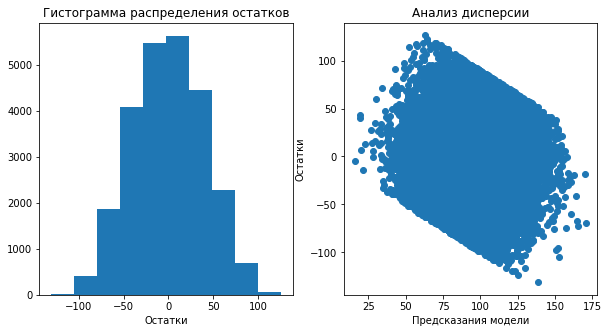

In [23]:
X_2 = geo_data_2.drop(['id', 'product'], axis=1) # входные признаки
y_2 = geo_data_2['product'] # целевой признак
y_train_2, y_valid_2 = function(X_2, y_2, num_col_names)

Регион 1:
- RMSE = 37.76
- Средний запас предсказанного сырья: 92.40 тыс. баррелей.

Регион 2:
- RMSE = 0.89
- Средний запас предсказанного сырья: 68.71 тыс. баррелей.

Регион 3:
- RMSE = 40.15
- Средний запас предсказанного сырья: 94.77 тыс. баррелей.

<font color='Black'><b>Вывод после обучения и проверки модели:</b></font><br>

- Разделены все данные на обучающую и валидационную выборки в соотношении 75:25.
- Созданы и обучены модели LinearRegression.
- Выполнены предсказания на валидационной выборке
- Сделаны предсказания по объёму сырья в скважинах.
- Создан список предсказаний по объёму сырья predictions_valid и список правильных ответов для каждого из регионов
- Рассчитаны значения среднего запаса предсказанного сырья для регионов и RMSE моделей

## Подготовка к расчёту прибыли

3.1. Все ключевые значения для расчётов сохраните в отдельных переменных.(из условий задачи)

In [24]:
NUMBER_POINTS   = 500  
BEST_POINTS  = 200     # Количество лучших скважин
BUDGET  = 1e07         # тыс рублей  
BARREL  = 450          # тыс рублей  
NUM_BOOTSTRAPS = 1000  # Количество бутстреп-итераций
np.random.seed(42)          # Для воспроизводимости

3.2. Рассчитайте достаточный объём сырья для безубыточной разработки новой скважины. Сравните полученный объём сырья со средним запасом в каждом регионе. 

In [25]:
print("Достаточный объём сырья для безубыточной разработки новой скважины: {0:.0f} тыс. баррелей\n". \
      format(BUDGET / BARREL))
print("Средний объем нефти в скважине, требуемый для безубыточной работы: {0:.0f} тыс. баррелей". \
      format(BUDGET / BARREL / BEST_POINTS))

Достаточный объём сырья для безубыточной разработки новой скважины: 22222 тыс. баррелей

Средний объем нефти в скважине, требуемый для безубыточной работы: 111 тыс. баррелей


Сравниваем средний объем нефти в скважине:

In [26]:
# Список массивов для сравнения
arrays = [y_train_0, y_train_1, y_train_2]

# Цикл сравнения среднего с 111
for i, arr in enumerate(arrays, start=1):
    mean = np.mean(arr)  # Среднее значение массива
    comparison = ">" if mean > 111 else ("<" if mean < 111 else "==")
    print(f"Регион {i}: Средний объем нефти в скважине = {mean:.2f} {comparison} 111")

Регион 1: Средний объем нефти в скважине = 92.56 < 111
Регион 2: Средний объем нефти в скважине = 68.86 < 111
Регион 3: Средний объем нефти в скважине = 94.95 < 111


Сравниваем средний объем нефти в скважине, предсказанный по валидационной выборке:

In [27]:
# Список массивов для сравнения
arrays = [y_valid_0, y_valid_1, y_valid_2]

# Цикл сравнения среднего с 111
for i, arr in enumerate(arrays, start=1):
    mean = np.mean(arr)  # Среднее значение массива
    comparison = ">" if mean > 111 else ("<" if mean < 111 else "==")
    print(f"Регион {i}: Средний объем нефти в скважине, предсказанный по валидационной выборке = {mean:.2f} {comparison} 111")

Регион 1: Средний объем нефти в скважине, предсказанный по валидационной выборке = 92.33 < 111
Регион 2: Средний объем нефти в скважине, предсказанный по валидационной выборке = 68.73 < 111
Регион 3: Средний объем нефти в скважине, предсказанный по валидационной выборке = 95.15 < 111


<font color='Black'><b>Вывод по этапу подготовки расчёта прибыли:</b></font><br>

Средний объем нефти во всех скважинах каждого из регионов меньше, чем требуется для безубыточной работы.

## Расчёт прибыли 

4.1. Выберите скважины с максимальными значениями предсказаний. 

4.2. Просуммируйте целевое значение объёма сырья, соответствующее этим предсказаниям.

4.3. Рассчитайте прибыль для полученного объёма сырья.


In [28]:
regions = ["Регион 1", "Регион 2", "Регион 3"]
# Список валидационных целевых значений для каждого региона
y_valid_list = [y_valid_0, y_valid_1, y_valid_2]

In [29]:
# Функция расчёта прибыли
def calc_profit(target, predictions, best_points=BEST_POINTS, cost_per_barrel=BARREL, budget=BUDGET):

    # Сортируем предсказания по убыванию и берем индексы лучших
    top_indices = predictions.sort_values(ascending=False).index[:best_points]
    
    # Суммируем целевые значения для этих индексов
    total_oil = target.loc[top_indices].sum()
    return total_oil * cost_per_barrel - budget

In [30]:
# Рассчитываем прибыль для каждого региона
profits = []
for i in range(3):
    # Преобразуем array в Series с теми же индексами, что и y_valid
    pred_series = pd.Series(predictions_valid[i], index=y_valid_list[i].index)
    
    # Рассчитываем прибыль
    profit = calc_profit(y_valid_list[i], pred_series)
    profits.append(profit)
    
    print(f'Прибыль для Региона по топ-200 скважинам {i+1}: {round(profit/1000000, 3)} млрд. руб')

Прибыль для Региона по топ-200 скважинам 1: 3.359 млрд. руб
Прибыль для Региона по топ-200 скважинам 2: 2.415 млрд. руб
Прибыль для Региона по топ-200 скважинам 3: 2.599 млрд. руб


<font color='Black'><b>Вывод по этапу расчёта прибыли:</b></font><br>

- все регионы потенциально прибыльные.

## Расчёт рисков 

 5.1. Примените технику Bootstrap с 1000 выборок, чтобы найти распределение прибыли.
 
 5.2. Найдите среднюю прибыль, 95%-й доверительный интервал и риск убытков. Убыток — это отрицательная прибыль.
 

In [31]:
results = {
    "Регион": [],
    "Средняя прибыль (млн руб.)": [],
    "95% CI Lower (млн руб.)": [],
    "95% CI Upper (млн руб.)": [],
    "Риск убытков (%)": []
}

In [32]:
for i in range(3):
    print(f"\n--- Анализ для {regions[i]} ---")
    pred_series = pd.Series(predictions_valid[i], index=y_valid_list[i].index)
    
    # Бутстрэп-выборки
    bootstrap_profits = []
    for _ in tqdm(range(NUM_BOOTSTRAPS)):
        # Выбираем случайные индексы с повторением
        sample_indices = np.random.choice(pred_series.index, size=NUMBER_POINTS, replace=True)
        sample_pred = pred_series.loc[sample_indices]
        sample_target = y_valid_list[i].loc[sample_indices]
        
        # Считаем прибыль
        profit = calc_profit(sample_target, sample_pred)
        bootstrap_profits.append(profit)
    
    # Рассчитываем статистики
    mean_profit = np.mean(bootstrap_profits)/1000
    ci_lower = np.percentile(bootstrap_profits, 2.5)/1000
    ci_upper = np.percentile(bootstrap_profits, 97.5)/1000
    risk_of_loss = (np.array(bootstrap_profits) < 0).mean() * 100
    
    # Сохраняем результаты
    results["Регион"].append(regions[i])
    results["Средняя прибыль (млн руб.)"].append(round(mean_profit, 2))
    results["95% CI Lower (млн руб.)"].append(round(ci_lower, 2))
    results["95% CI Upper (млн руб.)"].append(round(ci_upper, 2))
    results["Риск убытков (%)"].append(round(risk_of_loss, 2))

# Выводим таблицу результатов
results_df = pd.DataFrame(results)
print("\nРезультаты Bootstrap-анализа:")
print(results_df.to_string(index=False))


--- Анализ для Регион 1 ---


100%|██████████| 1000/1000 [00:01<00:00, 737.59it/s]



--- Анализ для Регион 2 ---


100%|██████████| 1000/1000 [00:01<00:00, 744.51it/s]



--- Анализ для Регион 3 ---


100%|██████████| 1000/1000 [00:01<00:00, 734.68it/s]


Результаты Bootstrap-анализа:
  Регион  Средняя прибыль (млн руб.)  95% CI Lower (млн руб.)  95% CI Upper (млн руб.)  Риск убытков (%)
Регион 1                      606.12                    10.09                  1246.37               2.5
Регион 2                      662.41                   148.80                  1186.98               0.3
Регион 3                      592.05                     2.46                  1254.83               2.5


 5.3. Напишите выводы: предложите регион для разработки скважин и обоснуйте выбор.

Рекомендация:


✅ Выбрать Регион 2, потому что:
- Максимальная прибыль
- Минимальный риск убытков 

<font color='Black'><b>Вывод по расчёту рисков:</b></font><br>

- Применили технику Bootstrap с 1000 выборок, чтобы найти распределение прибыли.
- Нашли для каждого региона:
    - среднюю прибыль, 
    - 95%-й доверительный интервал,
    - риск убытков.
- Проанализировали полученные результаты и рекомендовали бизнесу выбрать для разработки Регион 2, т.к. у него максимальная прибыль и минимальный риск убытков.

## Общий вывод

Цель исследования: для добывающей компании «ГлавРосГосНефть» обосновать решение где бурить новую скважину. 

Решенные задачи:

1. Данные по трем регионам были изучены и подготовлены к дальнейшим исследованиям.

2. Построена модель на данных по пробам нефти в трёх регионах.
    - Разделены все данные на обучающую и валидационную выборки в соотношении 75:25.
    - Созданы и обучены модели LinearRegression.
    - Выполнены предсказания на валидационной выборке
    - Сделаны предсказания по объёму сырья в скважинах.
    - Создан список предсказаний по объёму сырья predictions_valid и список правильных ответов для каждого из регионов
    - Рассчитаны значения среднего запаса предсказанного сырья для регионов и RMSE моделей

3. Выяснили, что средний объем нефти во всех скважинах каждого из регионов меньше, чем требуется для безубыточной работы. Соответственно нужно разрабатывать не все скважины, а лишь лучшие из них.

4. Проведен расчет прибыли по 200-м лучшим скважинам в каждом из регионов. Все три региона потенциально прибыльные.

5. Применена техника Bootstrap с 1000 выборок, для того чтобы найти распределение прибыли.

6. Итого: для разработки 200 лучших скважин рекомендован регион №2 (файл с исходными данными: 'geo_data_1.csv').